In [1]:
# Import Libraries #
import findspark
findspark.init()
from pyspark.sql.functions import split, col, array_contains, translate, round, size, when, udf, lit, mean, count, format_number
from pyspark.sql.types import TimestampType, MapType, IntegerType, StringType, ArrayType, FloatType, StructField, StructType
from pyspark.sql import SparkSession
from helper import *

spark = SparkSession.builder.appName('test').master("yarn") \
.config("spark.executor.instances", 12) \
.config("spark.executor.memory", "1G")  \
.getOrCreate()
## MUTE OUTPUT FROM SPARK
spark.sparkContext.setLogLevel("OFF")
#Event, White, Black, Result, WhiteElo, BlackElo, Opening, TimeControl, Termination, Moves,Eval, UTCTimestamp
schema = StructType([ \
    StructField("Event",StringType(),True), \
    StructField("White",StringType(),True), \
    StructField("Black",StringType(),True), \
    StructField("Result", StringType(), True), \
    StructField("WhiteElo", IntegerType(), True), \
    StructField("BlackElo", IntegerType(), True), \
    StructField("Opening",StringType(),True), \
    StructField("TimeControl",StringType(),True), \
    StructField("Termination",StringType(),True), \
    StructField("Moves", StringType(), True), \
    StructField("Eval", StringType(), True), \
    StructField("UTCTimestamp", TimestampType(), True) \
  ])
df = spark.read.csv("hdfs://namenode:9000/chess_2016_dataset/output/part*", schema=schema)

2023-04-13 14:15:21,492 INFO spark.SparkContext: Running Spark version 3.3.2
2023-04-13 14:15:21,900 INFO resource.ResourceUtils: ==============================================================
2023-04-13 14:15:21,901 INFO resource.ResourceUtils: No custom resources configured for spark.driver.
2023-04-13 14:15:21,902 INFO resource.ResourceUtils: ==============================================================
2023-04-13 14:15:21,902 INFO spark.SparkContext: Submitted application: test
2023-04-13 14:15:21,939 INFO resource.ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 4096, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
2023-04-13 14:15:21,962 INFO resource.ResourceProfile: Limiting resource is cpus at 1 tasks per executor
2023-04-13 14:15:21,966 INFO resource.ResourceProfileManager: Added Resou

In [2]:
spark

##### Check Shape of Data

In [3]:
print("shape: ", (df.count(), len(df.columns)))

2023-04-13 14:16:00,955 INFO datasources.FileSourceStrategy: Pushed Filters: 
2023-04-13 14:16:00,958 INFO datasources.FileSourceStrategy: Post-Scan Filters: 
2023-04-13 14:16:00,962 INFO datasources.FileSourceStrategy: Output Data Schema: struct<>
2023-04-13 14:16:01,902 INFO codegen.CodeGenerator: Code generated in 342.652467 ms
2023-04-13 14:16:02,014 INFO memory.MemoryStore: Block broadcast_0 stored as values in memory (estimated size 487.1 KiB, free 92.8 MiB)
2023-04-13 14:16:02,119 INFO memory.MemoryStore: Block broadcast_0_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 92.8 MiB)
2023-04-13 14:16:02,125 INFO storage.BlockManagerInfo: Added broadcast_0_piece0 in memory on namenode:43321 (size: 54.0 KiB, free: 93.2 MiB)
2023-04-13 14:16:02,134 INFO spark.SparkContext: Created broadcast 0 from count at NativeMethodAccessorImpl.java:0
2023-04-13 14:16:02,181 INFO execution.FileSourceScanExec: Planning scan with bin packing, max size: 4194304 bytes, open cost is consi

shape:  (1000, 12)


##### Convert columns to appropriate types

In [4]:
df = convert_types(df)
df.dtypes

[('Event', 'string'),
 ('White', 'string'),
 ('Black', 'string'),
 ('Result', 'string'),
 ('WhiteElo', 'int'),
 ('BlackElo', 'int'),
 ('Opening', 'string'),
 ('TimeControl', 'string'),
 ('Termination', 'string'),
 ('Moves', 'array<string>'),
 ('Eval', 'array<float>'),
 ('UTCTimestamp', 'timestamp')]

In [5]:
eval_difference = 3.0
eval_games = df.where(col("Eval")[0].isNotNull())
eval_games = eval_games.withColumn("WhiteBlunders", (find_white_blunders(col("Eval"), lit(eval_difference))))
eval_games = eval_games.withColumn("BlackBlunders", (find_black_blunders(col("Eval"), lit(eval_difference))))
eval_games.select("TimeControl", "White", "WhiteElo", "WhiteBlunders", "Black", "BlackElo", "BlackBlunders", "Result", "Termination") \
    .orderBy(col("WhiteBlunders").desc(), col("BlackBlunders").desc()).limit(10).toPandas().head(10)

2023-04-13 14:16:10,559 INFO datasources.FileSourceStrategy: Pushed Filters: IsNotNull(Eval)
2023-04-13 14:16:10,560 INFO datasources.FileSourceStrategy: Post-Scan Filters: isnotnull(Eval#10),isnotnull(cast(split(translate(Eval#10, ', ), ,, -1) as array<float>)[0])
2023-04-13 14:16:10,561 INFO datasources.FileSourceStrategy: Output Data Schema: struct<White: string, Black: string, Result: string, WhiteElo: int, BlackElo: int ... 6 more fields>
2023-04-13 14:16:10,671 INFO codegen.CodeGenerator: Code generated in 35.950063 ms
2023-04-13 14:16:10,720 INFO codegen.CodeGenerator: Code generated in 29.033987 ms
2023-04-13 14:16:10,903 INFO storage.BlockManagerInfo: Removed broadcast_0_piece0 on namenode:43321 in memory (size: 54.0 KiB, free: 93.3 MiB)
2023-04-13 14:16:10,937 INFO storage.BlockManagerInfo: Removed broadcast_0_piece0 on datanode1:40747 in memory (size: 54.0 KiB, free: 2004.6 MiB)
2023-04-13 14:16:11,009 INFO codegen.CodeGenerator: Code generated in 193.63679 ms
2023-04-13 14:

,TimeControl,White,WhiteElo,WhiteBlunders,Black,BlackElo,BlackBlunders,Result,Termination
0,600+0,dwp5321,1362,12,jujugaga,1295,9,1/2-1/2,Normal
1,480+0,joelbackman,1660,7,Rainbow52,1698,4,1/2-1/2,Time forfeit
2,300+0,hritic333,1812,5,jessehf,1799,2,0-1,Normal
3,90+0,Bogomdan,1380,5,prefe,1646,2,0-1,Time forfeit
4,600+0,dominguez1986,2005,4,yamyam15,1837,5,1-0,Normal
5,60+0,StEustache,1841,4,anirudhmehra,1545,3,1-0,Time forfeit
6,180+0,zelenimatej,1875,4,Andre_Sky,1672,3,1-0,Time forfeit
7,600+0,M_as19,1217,4,WattstheLoveguru,1288,2,0-1,Normal
8,900+5,venerabile48,1946,4,meev,1965,1,0-1,Normal
9,900+0,Sahinsah,1639,3,aerdna87,1634,9,1-0,Normal


##### Plot Most Blundered Game

In [6]:
eval = eval_games.select("Eval").orderBy(col("WhiteBlunders").desc()).collect()[0][0]
white_blunders = eval_games.select("WhiteBlunders").orderBy(col("WhiteBlunders").desc()).collect()[0][0]
black_blunders = eval_games.select("BlackBlunders").orderBy(col("WhiteBlunders").desc()).collect()[0][0]
white_name = eval_games.select("White").orderBy(col("WhiteBlunders").desc()).collect()[0][0]
black_name = eval_games.select("Black").orderBy(col("WhiteBlunders").desc()).collect()[0][0]
white_elo = eval_games.select("WhiteElo").orderBy(col("WhiteBlunders").desc()).collect()[0][0]
black_elo = eval_games.select("BlackElo").orderBy(col("WhiteBlunders").desc()).collect()[0][0]

2023-04-13 14:16:14,023 INFO datasources.FileSourceStrategy: Pushed Filters: IsNotNull(Eval)
2023-04-13 14:16:14,024 INFO datasources.FileSourceStrategy: Post-Scan Filters: isnotnull(Eval#10),isnotnull(cast(split(translate(Eval#10, ', ), ,, -1) as array<float>)[0])
2023-04-13 14:16:14,024 INFO datasources.FileSourceStrategy: Output Data Schema: struct<Eval: string>
2023-04-13 14:16:14,120 INFO codegen.CodeGenerator: Code generated in 27.819199 ms
2023-04-13 14:16:14,172 INFO codegen.CodeGenerator: Code generated in 41.107108 ms
2023-04-13 14:16:14,179 INFO memory.MemoryStore: Block broadcast_5 stored as values in memory (estimated size 487.1 KiB, free 92.2 MiB)
2023-04-13 14:16:14,204 INFO memory.MemoryStore: Block broadcast_5_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 92.2 MiB)
2023-04-13 14:16:14,205 INFO storage.BlockManagerInfo: Added broadcast_5_piece0 in memory on namenode:43321 (size: 54.0 KiB, free: 93.2 MiB)
2023-04-13 14:16:14,207 INFO spark.SparkContext:

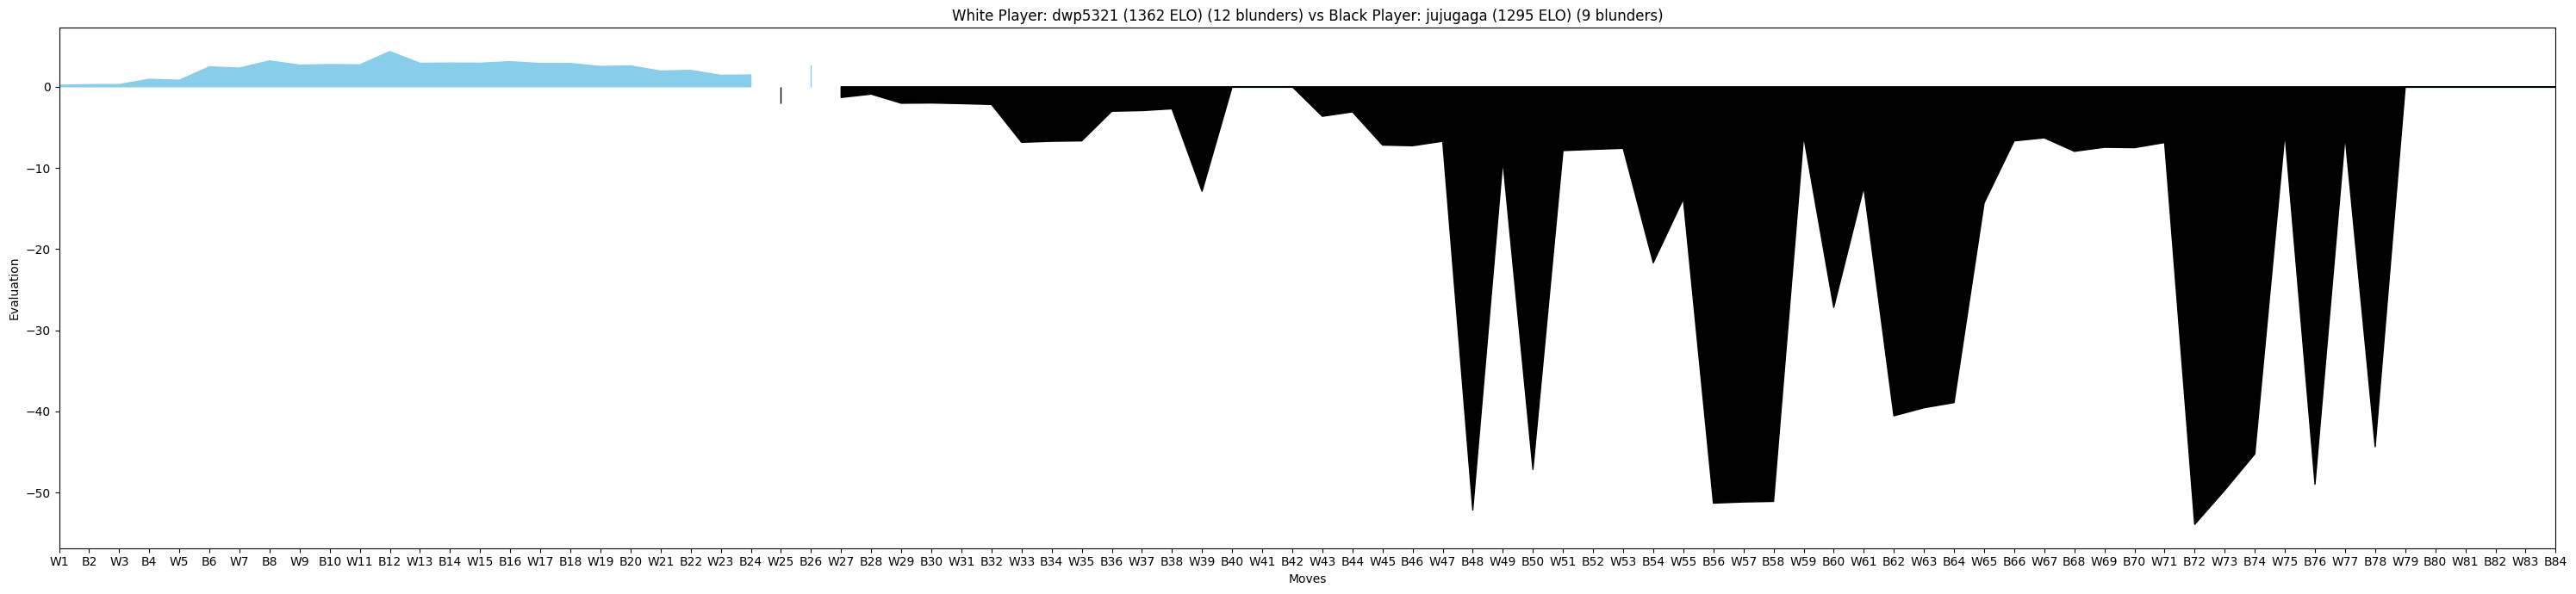

In [7]:
eval = [e for e in eval if abs(e) < 1000]
black_and_white = [f"W{idx+1}" if idx%2==0 or idx==0 else f"B{idx+1}" for idx in range(len(eval))]
y2 = np.array([0 for _ in range(len(black_and_white))])
fig, ax = plt.subplots(figsize=(30,7))

ax.fill_between(black_and_white, eval, y2, where=eval>=y2, color="skyblue")
ax.fill_between(black_and_white, eval, y2, where=eval<=y2, color="black")
ax.set_title(f"""White Player: {white_name} ({white_elo} ELO) ({white_blunders} blunders) vs \
Black Player: {black_name} ({black_elo} ELO) ({black_blunders} blunders)""")
ax.set_xlabel("Moves")
ax.set_ylabel("Evaluation")
ax.margins(x=0)

fig.tight_layout()
plt.savefig("chess_2016_dataset/images/blunder.png")

2023-04-13 14:16:28,170 INFO datasources.FileSourceStrategy: Pushed Filters: IsNotNull(Eval)
2023-04-13 14:16:28,171 INFO datasources.FileSourceStrategy: Post-Scan Filters: isnotnull(Eval#10),isnotnull(cast(split(translate(Eval#10, ', ), ,, -1) as array<float>)[0])
2023-04-13 14:16:28,173 INFO datasources.FileSourceStrategy: Output Data Schema: struct<Eval: string>
2023-04-13 14:16:28,246 INFO memory.MemoryStore: Block broadcast_33 stored as values in memory (estimated size 487.1 KiB, free 88.3 MiB)
2023-04-13 14:16:28,271 INFO memory.MemoryStore: Block broadcast_33_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 88.2 MiB)
2023-04-13 14:16:28,272 INFO storage.BlockManagerInfo: Added broadcast_33_piece0 in memory on namenode:43321 (size: 54.0 KiB, free: 92.7 MiB)
2023-04-13 14:16:28,274 INFO spark.SparkContext: Created broadcast 33 from collect at /home/ubuntu/chess_project/helper.py:45
2023-04-13 14:16:28,276 INFO execution.FileSourceScanExec: Planning scan with bin pac

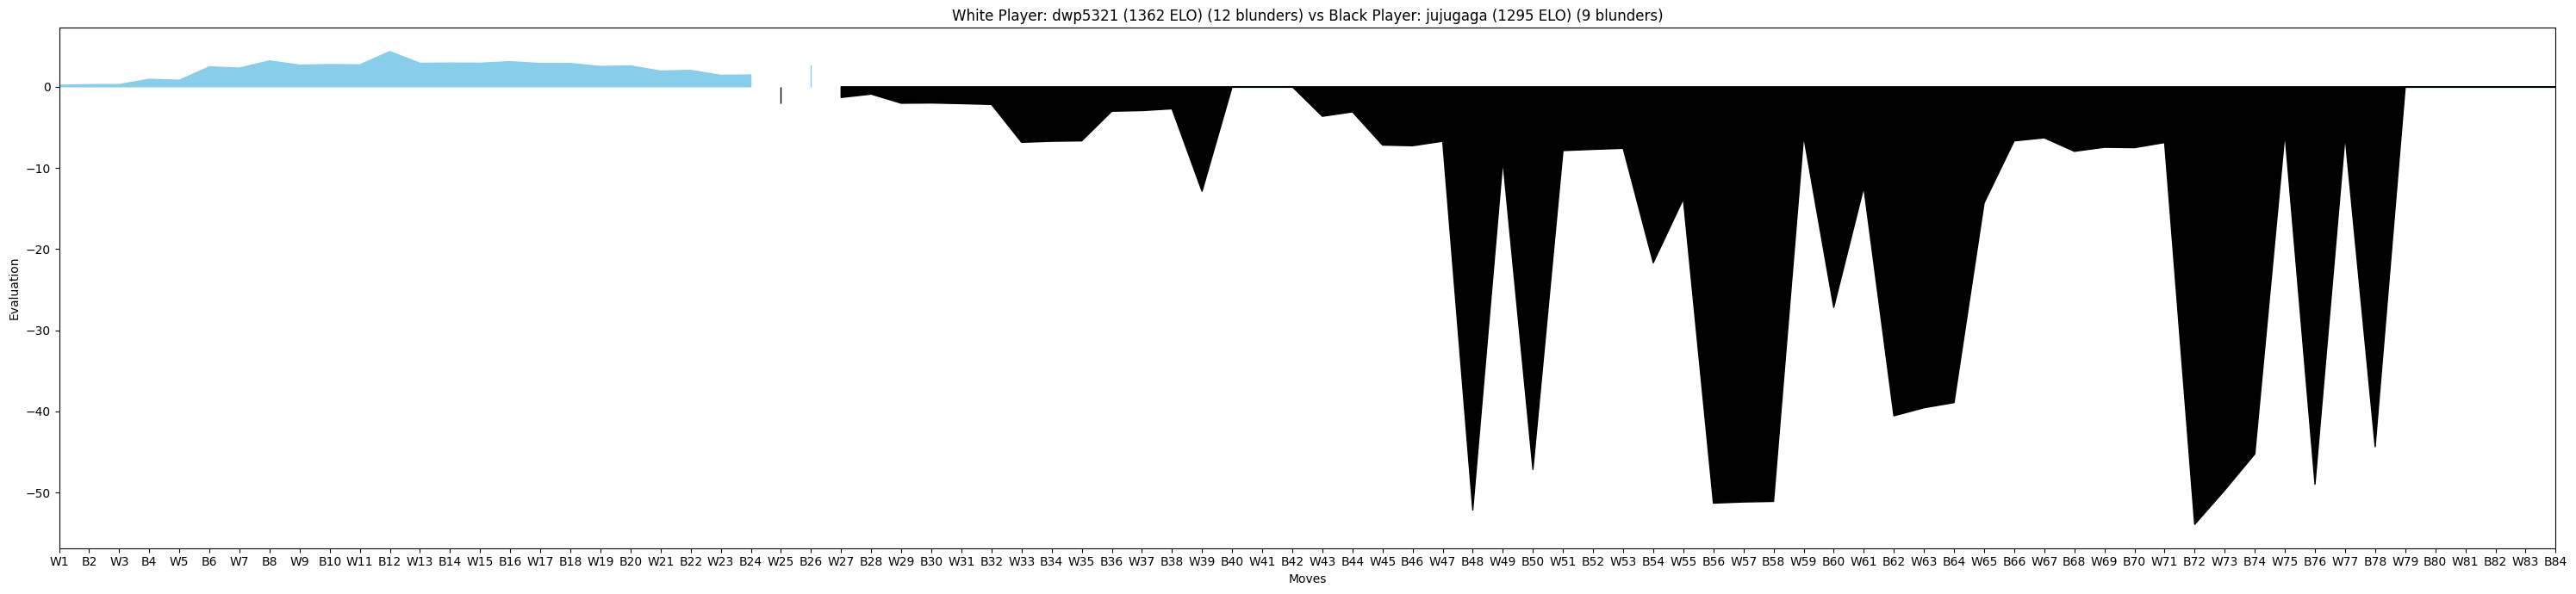

In [8]:
plot_eval_game(eval_games)

### Group By
- Timecontrol ~ (60, 120, 180, 600) etc...
- Elo-Brackets ~ ([1200, 1400], [1500, 1700], [2000-2200]) etc...

In [9]:
time_control_white_blunders_averages = eval_games.groupBy("TimeControl").agg(mean("WhiteBlunders"), count("TimeControl")).withColumn("avg(WhiteBlunders)", format_number("avg(WhiteBlunders)", 1))
time_control_black_blunders_averages = eval_games.groupBy("TimeControl").agg(mean("BlackBlunders"), count("TimeControl")).withColumn("avg(BlackBlunders)", format_number("avg(BlackBlunders)", 1))
time_control_white_blunders_averages.orderBy(col("avg(WhiteBlunders)").desc()).where(col("count(TimeControl)")>10000).limit(10).toPandas().head()

2023-04-13 14:16:34,833 INFO datasources.FileSourceStrategy: Pushed Filters: IsNotNull(Eval)
2023-04-13 14:16:34,834 INFO datasources.FileSourceStrategy: Post-Scan Filters: isnotnull(Eval#10),isnotnull(cast(split(translate(Eval#10, ', ), ,, -1) as array<float>)[0])
2023-04-13 14:16:34,835 INFO datasources.FileSourceStrategy: Output Data Schema: struct<TimeControl: string, Eval: string>
2023-04-13 14:16:35,151 INFO codegen.CodeGenerator: Code generated in 173.210105 ms
2023-04-13 14:16:35,174 INFO memory.MemoryStore: Block broadcast_61 stored as values in memory (estimated size 487.1 KiB, free 88.9 MiB)
2023-04-13 14:16:35,203 INFO memory.MemoryStore: Block broadcast_61_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 88.9 MiB)
2023-04-13 14:16:35,204 INFO storage.BlockManagerInfo: Added broadcast_61_piece0 in memory on namenode:43321 (size: 54.0 KiB, free: 92.8 MiB)
2023-04-13 14:16:35,209 INFO spark.SparkContext: Created broadcast 61 from toPandas at /tmp/ipykernel_2655

,TimeControl,avg(WhiteBlunders),count(TimeControl)


In [10]:
time_control_black_blunders_averages.orderBy(col("avg(BlackBlunders)").desc()).where(col("count(TimeControl)")>100000).limit(10).toPandas().head()

2023-04-13 14:16:36,622 INFO datasources.FileSourceStrategy: Pushed Filters: IsNotNull(Eval)
2023-04-13 14:16:36,622 INFO datasources.FileSourceStrategy: Post-Scan Filters: isnotnull(Eval#10),isnotnull(cast(split(translate(Eval#10, ', ), ,, -1) as array<float>)[0])
2023-04-13 14:16:36,623 INFO datasources.FileSourceStrategy: Output Data Schema: struct<TimeControl: string, Eval: string>
2023-04-13 14:16:36,675 INFO memory.MemoryStore: Block broadcast_64 stored as values in memory (estimated size 487.1 KiB, free 91.2 MiB)
2023-04-13 14:16:36,699 INFO memory.MemoryStore: Block broadcast_64_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 91.1 MiB)
2023-04-13 14:16:36,700 INFO storage.BlockManagerInfo: Added broadcast_64_piece0 in memory on namenode:43321 (size: 54.0 KiB, free: 93.1 MiB)
2023-04-13 14:16:36,702 INFO spark.SparkContext: Created broadcast 64 from toPandas at /tmp/ipykernel_265592/1036532255.py:1
2023-04-13 14:16:36,705 INFO execution.FileSourceScanExec: Planni

,TimeControl,avg(BlackBlunders),count(TimeControl)


In [11]:
a = eval_games.select("Moves") \
    .orderBy(col("WhiteBlunders").desc(), col("BlackBlunders").desc()).limit(1).take(1)[0][0]
print([x.replace("'","").replace('"', "").strip("'") for x in a])

2023-04-13 14:16:38,059 INFO datasources.FileSourceStrategy: Pushed Filters: IsNotNull(Eval)
2023-04-13 14:16:38,059 INFO datasources.FileSourceStrategy: Post-Scan Filters: isnotnull(Eval#10),isnotnull(cast(split(translate(Eval#10, ', ), ,, -1) as array<float>)[0])
2023-04-13 14:16:38,060 INFO datasources.FileSourceStrategy: Output Data Schema: struct<Moves: string, Eval: string>
2023-04-13 14:16:38,083 INFO codegen.CodeGenerator: Code generated in 17.579519 ms
2023-04-13 14:16:38,131 INFO codegen.CodeGenerator: Code generated in 35.328299 ms
2023-04-13 14:16:38,193 INFO codegen.CodeGenerator: Code generated in 49.82 ms
2023-04-13 14:16:38,202 INFO memory.MemoryStore: Block broadcast_67 stored as values in memory (estimated size 487.1 KiB, free 90.5 MiB)
2023-04-13 14:16:38,229 INFO memory.MemoryStore: Block broadcast_67_piece0 stored as bytes in memory (estimated size 54.0 KiB, free 90.4 MiB)
2023-04-13 14:16:38,230 INFO storage.BlockManagerInfo: Added broadcast_67_piece0 in memory on

['d4', ' Nf6', ' c4', ' Ng4', ' h3', ' Nxf2', ' Kxf2', ' d5', ' e3', ' dxc4', ' Bxc4', ' Be6', ' b3', ' Bxc4', ' bxc4', ' c5', ' Ne2', ' cxd4', ' Nxd4', ' e5', ' Qa4+', ' Nd7', ' Nf3', ' e4', ' Nfd2', ' f5', ' g4', ' fxg4', ' hxg4', ' Qf6+', ' Ke2', ' Qxa1', ' Nxe4', ' Qxb1', ' c5', ' Bxc5', ' Nxc5', ' O-O-O', ' Qxa7', ' Nxc5', ' Qxc5+', ' Kb8', ' Rh5', ' Qxa2+', ' Bd2', ' Rxd2+', ' Kf3', ' Qf7+', ' Rf5', ' Qd7', ' e4', ' Rd3+', ' Kf4', ' Rc8', ' Qe5+', ' Rd6', ' Qb2', ' g6', ' Rb5', ' Qf7+', ' Ke3', ' b6', ' e5', ' Rdc6', ' Rxb6+', ' Rxb6', ' Qxb6+', ' Qb7', ' Qd6+', ' Rc7', ' e6', ' Qb3+', ' Kf4', ' Kb7', ' e7', ' g5+', ' Kxg5', ' Qb5+', ' Kh6', ' Qe8', ' Kxh7', ' Qxe7+', ' Qxe7', ' Rxe7+', ' Kg6', ' Kc6', ' g5', ' Kd6', ' Kf6', ' Re8', ' g6', ' Kd7', ' g7', ' Rg8', ' Kf7', ' Rxg7+', ' Kxg7']


2023-04-13 14:16:38,503 INFO scheduler.TaskSetManager: Finished task 0.0 in stage 66.0 (TID 49) in 232 ms on datanode1 (executor 3) (1/1)
2023-04-13 14:16:38,503 INFO cluster.YarnScheduler: Removed TaskSet 66.0, whose tasks have all completed, from pool 
2023-04-13 14:16:38,505 INFO scheduler.DAGScheduler: ResultStage 66 (take at /tmp/ipykernel_265592/3532045529.py:1) finished in 0.248 s
2023-04-13 14:16:38,505 INFO scheduler.DAGScheduler: Job 49 is finished. Cancelling potential speculative or zombie tasks for this job
2023-04-13 14:16:38,505 INFO cluster.YarnScheduler: Killing all running tasks in stage 66: Stage finished
2023-04-13 14:16:38,507 INFO scheduler.DAGScheduler: Job 49 finished: take at /tmp/ipykernel_265592/3532045529.py:1, took 0.252383 s
2023-04-13 14:16:38,532 INFO codegen.CodeGenerator: Code generated in 13.594606 ms
